# Unemployment Analysis

- Your analysis here
  
---

In [325]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [326]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [327]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [328]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [410]:
%pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.3/251.3 kB 3.6 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [716]:
from scipy import stats

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan

In [1231]:
from statsmodels.formula.api import ols

In [723]:
from scipy.stats import shapiro

In [329]:
import seaborn as sns
import statsmodels.api as sm

In [330]:
# Dependencies and Setup
import pandas as pd
from pathlib import Path
import os





In [331]:

import matplotlib.pyplot as plt

In [ ]:
import numpy as np

In [806]:
import statsmodels.formula.api as smf

In [1228]:
from statsmodels.stats.anova import anova_lm

In [332]:
#find current directory
current_dir = os.getcwd()
print(current_dir)

/Users/wenlirui/Desktop/project1/Code


In [1135]:
#load yearly education data
education_to_load =os.path.join(current_dir, "Data", "Education attainment.csv")
education_data=pd.read_csv(education_to_load)


In [1136]:
#create month column for each year in education data
value_count = education_data['year'].count()
months_data = {
    'Month': [str(month).zfill(2) for month in range(1, 13)] * value_count   # Repeat months for each year
}
months_df = pd.DataFrame(months_data)
monthly_edu = pd.concat([education_data]*12, ignore_index = True)
monthly_edu = monthly_edu.sort_values(by=['year'])
monthly_edu = monthly_edu.reset_index(drop=True)
monthly_edu_data = pd.concat([monthly_edu, months_df], axis=1)
#drop NA data
monthly_edu_data= monthly_edu_data.dropna()
# convert year data type to integer
monthly_edu_data['year'] = monthly_edu_data['year'].astype(int)

#create year-month column
monthly_edu_data['YearMonth'] = pd.to_datetime(monthly_edu_data['year'].astype(str) + '-' + monthly_edu_data['Month'].astype(str) + '-01')
#Clean up Education Data
monthly_edu_data=monthly_edu_data[['YearMonth','% Highest degree is middle school', '% Highest degree is High School', '% Highest degree is  College (4 + years)']]
#convert degree % columns type from object to float
monthly_edu_data['% Highest degree is middle school']=monthly_edu_data['% Highest degree is middle school'].str.rstrip('%').astype(float) / 100
monthly_edu_data['% Highest degree is High School']=monthly_edu_data['% Highest degree is High School'].str.rstrip('%').astype(float) / 100
monthly_edu_data['% Highest degree is  College (4 + years)']=monthly_edu_data['% Highest degree is  College (4 + years)'].str.rstrip('%').astype(float) / 100
nan_counts = monthly_edu_data.isna().sum()


In [1137]:
#exam unemployment data
unemployment_to_load = os.path.join(current_dir, "Data", "MonthlyUnemployment.csv")
unemployment_data = pd.read_csv(unemployment_to_load)

In [1138]:
#transform unemployment data
unemployment_df = unemployment_data.melt(id_vars=['Year'], var_name='Month', value_name='Unemployment Rate')

month_map = {
    'Jan': '01',
    'Feb': '02',
    'Mar': '03',
    'Apr': '04',
    'May': '05',
    'Jun': '06',
    'Jul': '07',
    'Aug': '08',
    'Sep': '09',
    'Oct': '10',
    'Nov': '11',
    'Dec': '12'
    # Add more months as needed
}
unemployment_df['MonthNum'] = unemployment_df['Month'].map(month_map)
unemployment_df['YearMonth'] = unemployment_df['Year'].astype(str) + '-' + unemployment_df['MonthNum'] + '-01'
unemployment_df['YearMonth'] = unemployment_df['Year'].astype(str) + '-' + unemployment_df['MonthNum'] + '-01' 
unemployment_df = unemployment_df[['YearMonth', 'Unemployment Rate' ]]
unemployment_df['YearMonth'] = pd.to_datetime(unemployment_df['YearMonth'])


In [ ]:
#exam men unemployment data
men_unemploy_to_load = os.path.join(current_dir, "Data", "Men_Unemployment.csv")
unemployment_men = pd.read_csv(men_unemploy_to_load)
unemployment_men ['YearMonth'] = pd.to_datetime(unemployment_men ['DATE'])

In [1139]:
#exam women unemployment data
women_unemploy_to_load = os.path.join(current_dir, "Data", "Women_Unemployment.csv")
unemployment_women = pd.read_csv(women_unemploy_to_load )
unemployment_women ['YearMonth'] = pd.to_datetime(unemployment_women ['DATE'])

In [1140]:
#load and exam gdp data
gdp_to_load = os.path.join(current_dir, "Data", "MonthlyGDP.csv")
gdp_data = pd.read_csv(gdp_to_load)
# Define a function to correctly parse two-digit years
def parse_date(date_str):
    # Use pd.to_datetime with dayfirst=False for m/d/y format
    date = pd.to_datetime(date_str, format='%m/%d/%y', errors='coerce')
    # Fix the century if necessary
    if date.year > pd.Timestamp.now().year:
        date = date.replace(year=date.year - 100)
    return date

# Create a YearMonth column
gdp_data['YearMonth'] = gdp_data['DATE'].apply(parse_date)
gdp_data['YearMonth'] = gdp_data['YearMonth'].dt.strftime('%Y-%m-%d')
gdp_data = gdp_data[['YearMonth','USALORSGPNOSTSAM']]
gdp_data['YearMonth'] = pd.to_datetime(gdp_data['YearMonth'])

#Prepare data to calc gdp growth
gdp_data['USALORSGPNOSTSAM1']= gdp_data['USALORSGPNOSTSAM'].shift(-1)

In [1141]:
#load and explore laborforce_data
laborforce_to_load = os.path.join(current_dir, "Data", "Labor force participation rate_monthly.csv")
laborforce_data = pd.read_csv(laborforce_to_load)
#change laborforce column name
laborforce_data.rename(columns={'observation_date': 'YearMonth', 'CIVPART': 'Labor Force Participation'}, inplace=True)
laborforce_data['YearMonth'] = pd.to_datetime(laborforce_data['YearMonth'])
laborforce_data.head()

,YearMonth,Labor Force Participation
0,1948-01-01,58.6
1,1948-02-01,58.9
2,1948-03-01,58.5
3,1948-04-01,59.0
4,1948-05-01,58.3


In [1142]:
#load and explore cpi data
cpi_to_load = os.path.join(current_dir, "Data", "CPIAUCSL.csv")
cpi_data = pd.read_csv(cpi_to_load)
#change cpi column name
cpi_data.rename(columns={'DATE': 'YearMonth', 'CPIAUCSL': 'CPI'}, inplace=True)
cpi_data['YearMonth'] = pd.to_datetime(cpi_data['YearMonth'])

In [1143]:
#load and exam immigration
immigration_to_load = os.path.join(current_dir, "Data", "MPI-Data-Hub_Immigrants_N-Percent-US-Population_2022_0.xlsx")
immigration_data = pd.read_excel(immigration_to_load)
#create month column for each year in education data
value_count1 = immigration_data['YEAR'].count()
months_data1 = {
    'Month': [str(month).zfill(2) for month in range(1, 13)] * value_count1   # Repeat months for each year
}
months_df1 = pd.DataFrame(months_data1)
monthly_immigration = pd.concat([immigration_data]*12, ignore_index = True)
monthly_immig_data = pd.concat([monthly_immigration, months_df1], axis=1)
monthly_immig_data = monthly_immig_data.sort_values(by=['YEAR', "Month"])


In [1144]:
#remove data older than 1946 as other variables dont have those data
monthly_immig_data = monthly_immig_data[monthly_immig_data['YEAR']>1946]
#organize the data by year and month and drop NA data
monthly_immig_data = monthly_immig_data.sort_values(by=['YEAR', "Month"])
monthly_immig_data = monthly_immig_data.reset_index(drop=True)
# convert year data type to integer
monthly_immig_data['YEAR'] = monthly_immig_data['YEAR'].astype(int)

#create year-month column
monthly_immig_data['YearMonth'] = pd.to_datetime(monthly_immig_data['YEAR'].astype(str) + '-' + monthly_immig_data['Month'].astype(str) + '-01')
#Clean up immigration Data
monthly_immig_data=monthly_immig_data[['YearMonth','NUMBER OF DOCUMENTED IMMIGRANTS']]

In [1145]:
#load yearly education data
president_to_load =os.path.join(current_dir, "Data", "US_Unemployment_Rates.csv")
president_data=pd.read_csv(president_to_load)
#Clean up the data
president_data = president_data[['Date','Party']]
president_data['President Party Affiliation'] = president_data['Party'].map({'Republican': 1, 'Democratic': 0})
president_data .rename(columns={'Date': 'YearMonth', 'President Party Affiliation': 'President Party Affiliation'}, inplace=True)
president_data['YearMonth'] = pd.to_datetime(president_data ['YearMonth'])
president_data = president_data[['YearMonth','President Party Affiliation']]

In [1146]:
fedfund_to_load =os.path.join(current_dir, "Data", "US_Unemployment_Intrest.csv")
fedfund_data=pd.read_csv(fedfund_to_load)
#Clean up the data and change the fed fund rate scale
fedfund_data = fedfund_data[['DATE','FEDFUNDS']]
fedfund_data .rename(columns={'DATE': 'YearMonth', 'FEDFUNDS': 'FEDFUNDS'}, inplace=True)
fedfund_data['YearMonth'] = pd.to_datetime(president_data ['YearMonth'])
fedfund_data['FEDFUNDS'] /100
fedfund_data.head()

,YearMonth,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83


In [635]:
#Running multiple regression analysis without data transformation

# X = df1[['Labor Force Participation', 'Real GDP Growth','Lagged Real GDP Growth','Middle School Degree%','High School Degree%', 'College Degree%']]
# X = sm.add_constant(X)
# model1 = sm.OLS(df1['Unemployment Rate'], X).fit()
# print("Multiple regression without log transformation:")
# print(model1.summary())

#DATA exploration

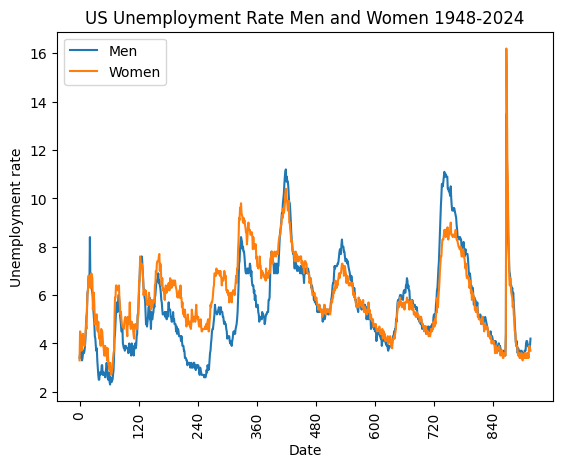

In [1317]:
# make empty chart and figure
figure,ax = plt.subplots()
#add data men to the line plot, ploted the chart
ax.plot(unemployment_men.index,unemployment_men["LNS14000001"])
#add data women to the line plot, ploted the chart
ax.plot(unemployment_women.index,unemployment_women["LNS14000002"])
#add title
ax.set_title("US Unemployment Rate Men and Women 1948-2024")
#label axis
ax.set_xlabel("Date")
ax.set_ylabel("Unemployment rate")
#cleanup date
ax.set_xticks(unemployment_men.index.values[0:-1:120])
plt.xticks(rotation = 90)
ax.legend(["Men", "Women"])

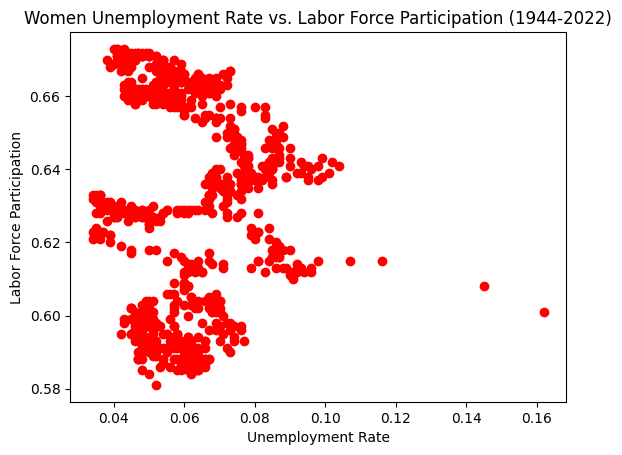

In [1327]:
plt.title("Women Unemployment Rate vs. Labor Force Participation (1944-2022)")
plt.xlabel("Unemployment Rate")
plt.ylabel("Labor Force Participation")

plt.scatter(x=df_women['Unemployment Rate'],y=df_women['Labor Force Participation'], marker="o", color="red")

plt.show()


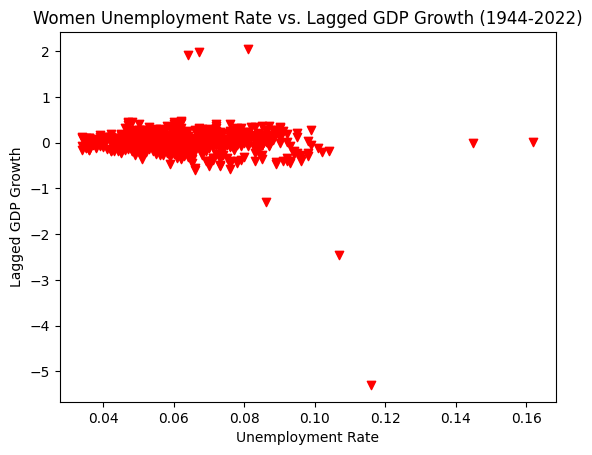

In [1324]:
plt.title("Women Unemployment Rate vs. Lagged GDP Growth (1944-2022)")
plt.xlabel("Unemployment Rate")
plt.ylabel("Lagged GDP Growth")

plt.scatter(x=df_women['Unemployment Rate'],y=df_women['Last Quarter Real GDP Growth'], marker="v", color="red")

plt.show()

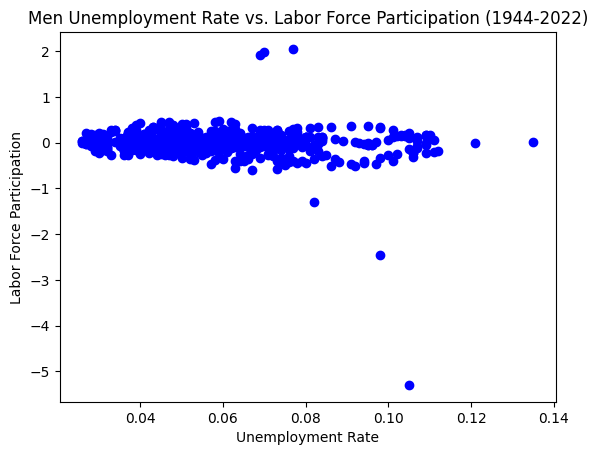

In [1325]:

plt.title("Men Unemployment Rate vs. Labor Force Participation (1944-2022)")
plt.xlabel("Unemployment Rate")
plt.ylabel("Labor Force Participation")

plt.scatter(x=df_men['Unemployment Rate'],y=df_men['Last Quarter Real GDP Growth'], marker="o", color="blue")

plt.show()

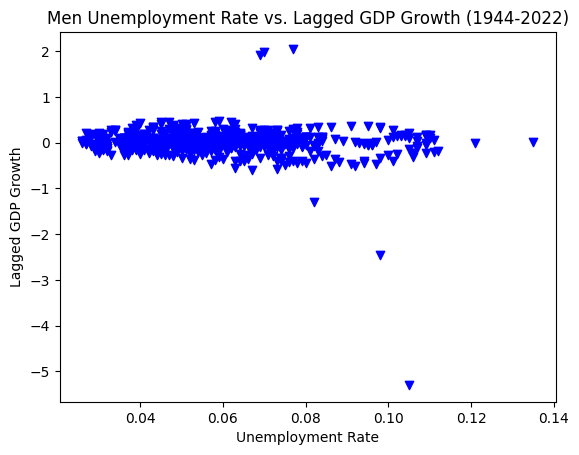

In [1329]:
plt.title("Men Unemployment Rate vs. Lagged GDP Growth (1944-2022)")
plt.xlabel("Unemployment Rate")
plt.ylabel("Lagged GDP Growth")

plt.scatter(x=df_men['Unemployment Rate'],y=df_men['Last Quarter Real GDP Growth'], marker="v", color="blue")

plt.show()

##Men Unemployment Analysis

In [1147]:
#merge all data for all men 
df_men= pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(unemployment_men, gdp_data, on = "YearMonth" ),laborforce_data, on = "YearMonth"),cpi_data, on = "YearMonth"),monthly_immig_data, on = "YearMonth", how = "left"),president_data, on = "YearMonth"),fedfund_data,on = "YearMonth")
df_men.head()


,DATE,LNS14000001,YearMonth,USALORSGPNOSTSAM,USALORSGPNOSTSAM1,Labor Force Participation,CPI,NUMBER OF DOCUMENTED IMMIGRANTS,President Party Affiliation,FEDFUNDS
0,1954-07-01,5.6,1954-07-01,97.80396,97.98277,58.4,26.86,208177.0,1.0,0.80
1,1954-08-01,6.0,1954-08-01,97.98277,98.24867,58.7,26.85,208177.0,1.0,1.22
2,1954-09-01,6.0,1954-09-01,98.24867,98.59119,59.2,26.81,208177.0,1.0,1.07
3,1954-10-01,5.7,1954-10-01,98.59119,98.99624,58.8,26.72,208177.0,1.0,0.85
4,1954-11-01,5.2,1954-11-01,98.99624,99.44441,58.6,26.78,208177.0,1.0,0.83


In [1148]:
#normalize GDP via CPI, and other data
df_men["Real GDP"] = df_men['USALORSGPNOSTSAM'] / df_men['CPI']
df_men["Real GDP1"] = df_men['USALORSGPNOSTSAM1'] / df_men['CPI']
df_men["Real GDP Growth"] = (df_men["Real GDP1"] - df_men["Real GDP"])/df_men["Real GDP"]*100
df_men=df_men[['YearMonth', 'LNS14000001','Labor Force Participation','Real GDP Growth','NUMBER OF DOCUMENTED IMMIGRANTS', 'President Party Affiliation','FEDFUNDS', "CPI"]]
#scale labor force and umemployment data
df_men['Labor Force Participation'] = df_men['Labor Force Participation']/100
df_men['LNS14000001'] = df_men['LNS14000001']/100
#add last quarter lagged real GDP growth and FED Fund
df_men["Lag4 Real GDP Growth"]= df_men['Real GDP Growth'].shift(4)
df_men["Lag4 FED Fund"]= df_men['FEDFUNDS'].shift(4)
df_men["Lag4 CPI"]= df_men['CPI'].shift(4)
df_men.head()


,YearMonth,LNS14000001,Labor Force Participation,Real GDP Growth,NUMBER OF DOCUMENTED IMMIGRANTS,President Party Affiliation,FEDFUNDS,CPI,Lag4 Real GDP Growth,Lag4 FED Fund,Lag4 CPI
0,1954-07-01,0.056,0.584,0.182825,208177.0,1.0,0.80,26.86,NaN,NaN,NaN
1,1954-08-01,0.060,0.587,0.271374,208177.0,1.0,1.22,26.85,NaN,NaN,NaN
2,1954-09-01,0.060,0.592,0.348626,208177.0,1.0,1.07,26.81,NaN,NaN,NaN
3,1954-10-01,0.057,0.588,0.410838,208177.0,1.0,0.85,26.72,NaN,NaN,NaN
4,1954-11-01,0.052,0.586,0.452714,208177.0,1.0,0.83,26.78,0.182825,0.8,26.86


In [1149]:
#change project 1 men dataset name
df_men.rename(columns={'YearMonth': 'Date', 'LNS14000001': 'Unemployment Rate', 'Labor Force Participation':'Labor Force Participation',
                    'Real GDP Growth':'Real GDP Growth', "Lag4 Real GDP Growth":"Last Quarter Real GDP Growth", "NUMBER OF DOCUMENTED IMMIGRANTS": "Number of Documented Immigrants",'President Party Affiliation':'President Party Affiliation','FEDFUNDS':'FED Funds', 'CPI':'CPI','Lag4 FED Fund':'Last Quarter FED Fund','Lag4 CPI':'Last Quarter CPI'}, inplace=True)
df_men.head()

,Date,Unemployment Rate,Labor Force Participation,Real GDP Growth,Number of Documented Immigrants,President Party Affiliation,FED Funds,CPI,Last Quarter Real GDP Growth,Last Quarter FED Fund,Last Quarter CPI
0,1954-07-01,0.056,0.584,0.182825,208177.0,1.0,0.80,26.86,NaN,NaN,NaN
1,1954-08-01,0.060,0.587,0.271374,208177.0,1.0,1.22,26.85,NaN,NaN,NaN
2,1954-09-01,0.060,0.592,0.348626,208177.0,1.0,1.07,26.81,NaN,NaN,NaN
3,1954-10-01,0.057,0.588,0.410838,208177.0,1.0,0.85,26.72,NaN,NaN,NaN
4,1954-11-01,0.052,0.586,0.452714,208177.0,1.0,0.83,26.78,0.182825,0.8,26.86


In [1150]:
#Create a US economic crisis column with dummy variable =1 if crisis and 0 otherwise
df_men['Year'] = df_men['Date'].dt.year

# Define the years considered as crisis years
crisis_years = [1948, 1949, 1953,1954,1957,1958,1960,1961,1969,1970,1973,1974,1975,1980,1981,1982,1990,1991,2001,2008,2009,2020]

# Create a new column 'Crisis' and set values based on the year
df_men['Crisis'] = df_men['Year'].apply(lambda x: 1 if x in crisis_years else 0)

df_men=df_men[['Date', 'Unemployment Rate','Labor Force Participation','Real GDP Growth','Number of Documented Immigrants', 'President Party Affiliation','FED Funds', "CPI",'Last Quarter FED Fund','Last Quarter CPI','Crisis','Last Quarter Real GDP Growth']]
# Display the DataFrame
df_men.head()

,Date,Unemployment Rate,Labor Force Participation,Real GDP Growth,Number of Documented Immigrants,President Party Affiliation,FED Funds,CPI,Last Quarter FED Fund,Last Quarter CPI,Crisis,Last Quarter Real GDP Growth
0,1954-07-01,0.056,0.584,0.182825,208177.0,1.0,0.80,26.86,NaN,NaN,1,NaN
1,1954-08-01,0.060,0.587,0.271374,208177.0,1.0,1.22,26.85,NaN,NaN,1,NaN
2,1954-09-01,0.060,0.592,0.348626,208177.0,1.0,1.07,26.81,NaN,NaN,1,NaN
3,1954-10-01,0.057,0.588,0.410838,208177.0,1.0,0.85,26.72,NaN,NaN,1,NaN
4,1954-11-01,0.052,0.586,0.452714,208177.0,1.0,0.83,26.78,0.8,26.86,1,0.182825


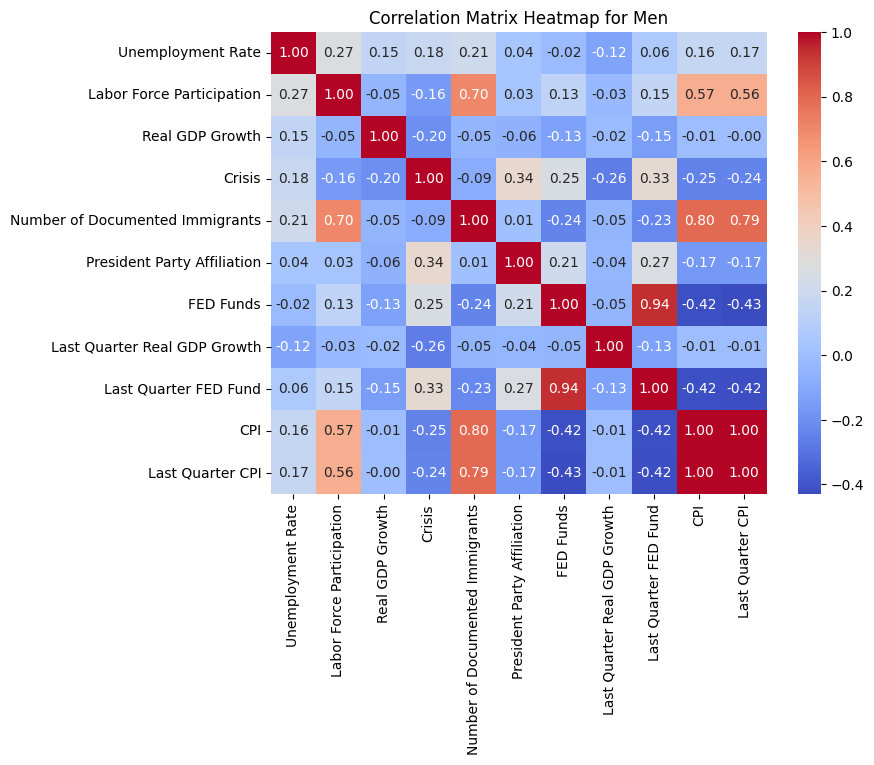

In [1151]:
#correlation analysis of all variables of interest for men
subset_columns_men = ['Unemployment Rate', 'Labor Force Participation', 'Real GDP Growth','Crisis',"Number of Documented Immigrants",'President Party Affiliation', 'FED Funds','Last Quarter Real GDP Growth',
'Last Quarter FED Fund','CPI','Last Quarter CPI']

# Compute the correlation matrix for the subset of columns
correlation_matrix_men = df_men[subset_columns_men].corr()
# print("\nCorrelation matrix for men unemployment rate:")
# print(correlation_matrix_men)

#print correlation for men
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_men, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap for Men')
plt.show()

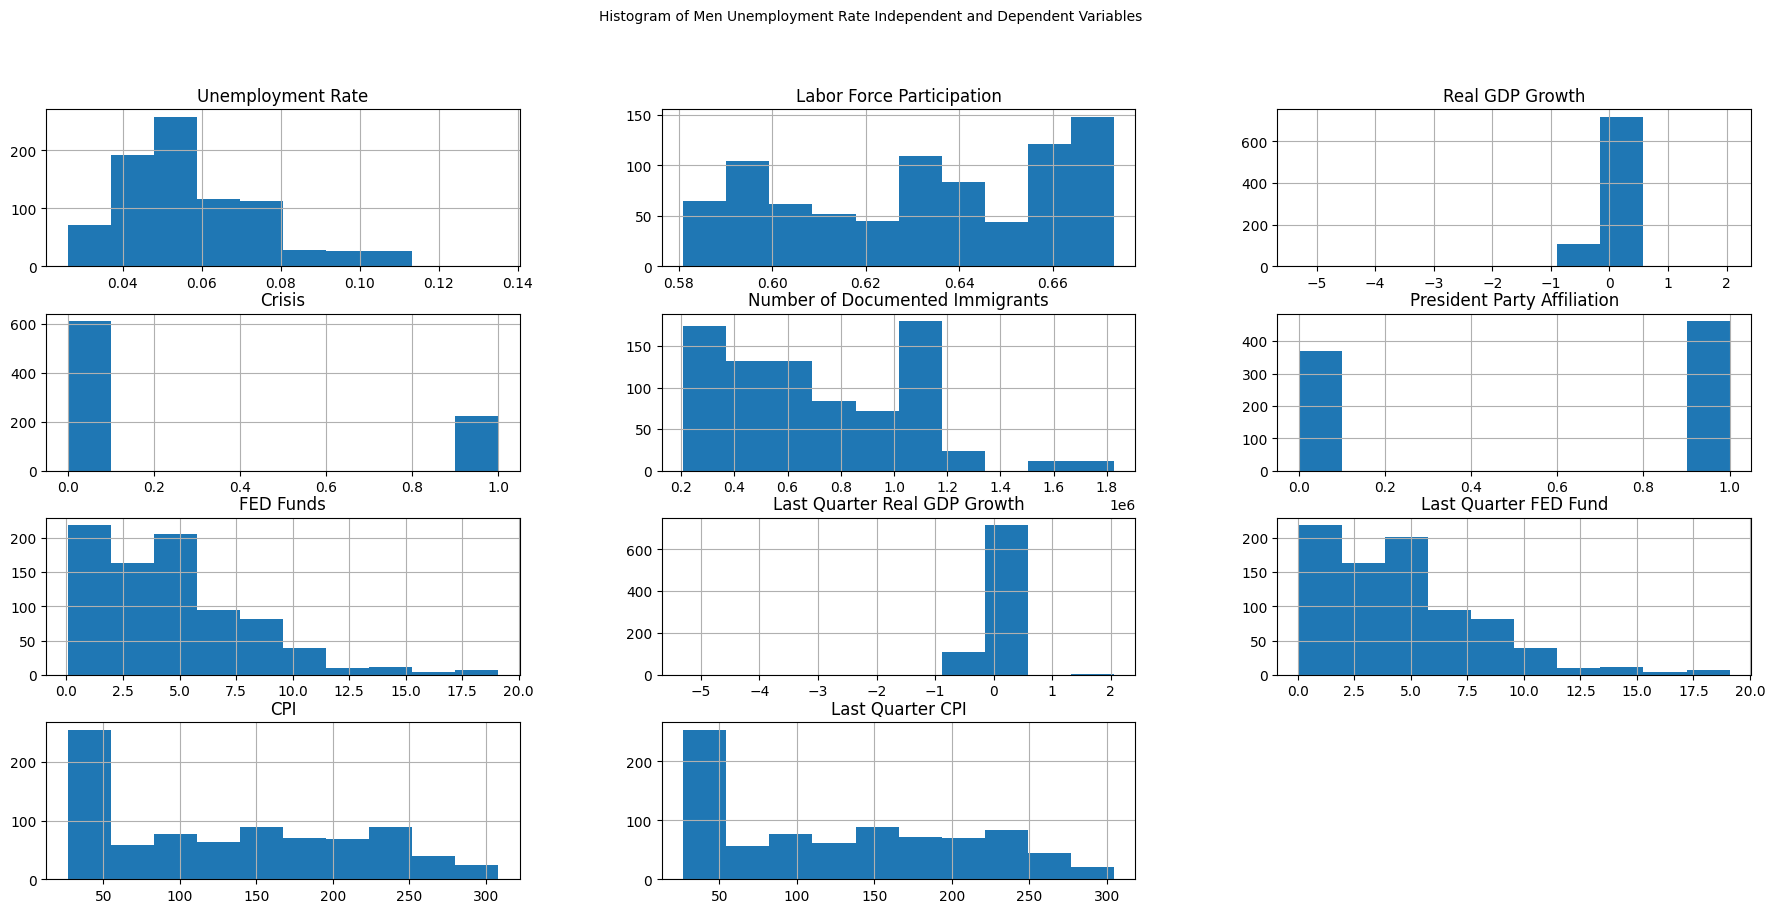

In [1152]:
# Create histograms for the subset of columns to understand if any data need transformation
df_men[subset_columns_men].hist(figsize=(22, 10), bins=10)  # Adjust figsize and bins as needed

# Add titles and labels
plt.suptitle('Histogram of Men Unemployment Rate Independent and Dependent Variables', fontsize=10)
plt.xlabel('Value', fontsize=8)
plt.ylabel('Frequency', fontsize=8)

# Show the plot
plt.show()

#Many data are skewed and require transformation

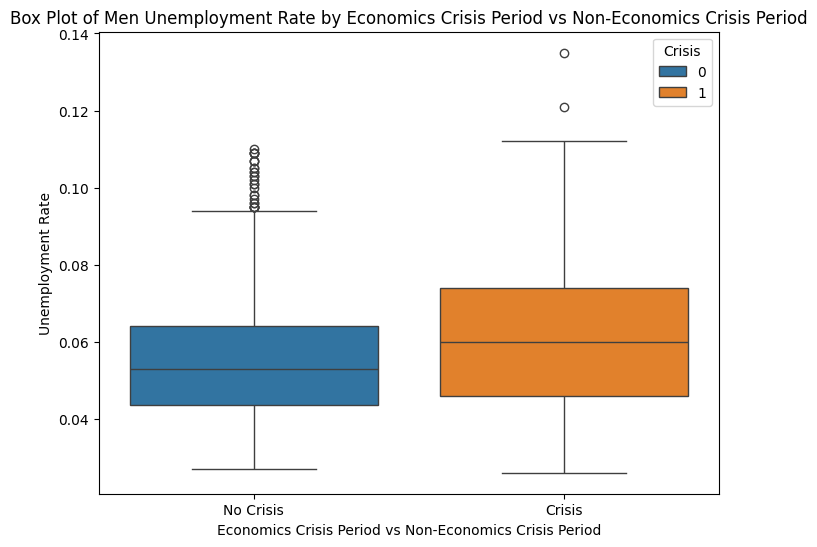

In [1153]:
# Create a box plot with hue for men
plt.figure(figsize=(8, 6))
sns.boxplot(x='Crisis', y='Unemployment Rate', hue='Crisis', data=df_men)
plt.title('Box Plot of Men Unemployment Rate by Economics Crisis Period vs Non-Economics Crisis Period')
plt.xlabel('Economics Crisis Period vs Non-Economics Crisis Period')
plt.ylabel('Unemployment Rate')
# Modify the x-axis labels
new_labels = ['No Crisis', 'Crisis']
plt.xticks(ticks=[0, 1], labels=new_labels)
plt.show()
#Outlier exist and need to be removed

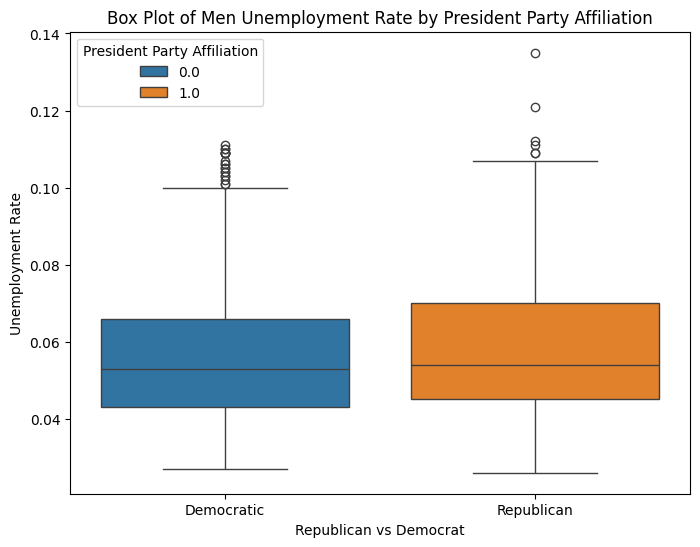

In [1247]:
# Create a box plot with hue for men
plt.figure(figsize=(8, 6))
sns.boxplot(x='President Party Affiliation', y='Unemployment Rate', hue='President Party Affiliation', data=df_men)
plt.title('Box Plot of Men Unemployment Rate by President Party Affiliation')
plt.xlabel('Republican vs Democrat')
plt.ylabel('Unemployment Rate')
# Modify the x-axis labels
new_labels = ['Democratic', 'Republican']
plt.xticks(ticks=[0, 1], labels=new_labels)
plt.show()

In [1154]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) to identify outlier
Q1 = df_men['Unemployment Rate'].quantile(0.25)
Q3 = df_men['Unemployment Rate'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers 
outliers_iqr = df_men[(df_men['Unemployment Rate'] < lower_bound) | (df_men['Unemployment Rate'] > upper_bound)]

# print("\nOutliers using IQR method:")
# print(outliers_iqr)

In [1155]:
#drop NA for men population for regression analysis
df_men=df_men.dropna()
nan_counts = df_men.isna().sum()
# print("Number of NaNs in each column:")
# print(nan_counts)

In [1156]:
#Adding crisis interaction term 
df_men2=df_men.copy()
df_men2['Crisis_FED'] = df_men2['Crisis']*df_men2['Last Quarter FED Fund']
df_men2['Crisis_Labor'] = df_men2['Crisis']*df_men2['Labor Force Participation']
df_men2['Crisis_GDP'] = df_men2['Crisis']*df_men2['Last Quarter Real GDP Growth']
df_men2['Crisis_President'] = df_men2['Crisis']*df_men2['President Party Affiliation']
df_men2['Crisis_CPI'] = df_men2['Crisis']*df_men2['CPI']
df_men2['Crisis_LastQCPI'] = df_men2['Crisis']*df_men2['Last Quarter CPI']

In [1157]:
#Drop outliers
df_men2 = df_men2[~((df_men2['Unemployment Rate'] < lower_bound) | (df_men2['Unemployment Rate'] > upper_bound))]
df_men2.head()

,Date,Unemployment Rate,Labor Force Participation,Real GDP Growth,Number of Documented Immigrants,President Party Affiliation,FED Funds,CPI,Last Quarter FED Fund,Last Quarter CPI,Crisis,Last Quarter Real GDP Growth,Crisis_FED,Crisis_Labor,Crisis_GDP,Crisis_President,Crisis_CPI,Crisis_LastQCPI
4,1954-11-01,0.052,0.586,0.452714,208177.0,1.0,0.83,26.78,0.80,26.86,1,0.182825,0.80,0.586,0.182825,1.0,26.78,26.86
5,1954-12-01,0.050,0.581,0.462691,208177.0,1.0,1.28,26.77,1.22,26.85,1,0.271374,1.22,0.581,0.271374,1.0,26.77,26.85
6,1955-01-01,0.048,0.586,0.439089,237790.0,1.0,1.39,26.77,1.07,26.81,0,0.348626,0.00,0.000,0.000000,0.0,0.00,0.00
7,1955-02-01,0.045,0.584,0.388965,237790.0,1.0,1.29,26.82,0.85,26.72,0,0.410838,0.00,0.000,0.000000,0.0,0.00,0.00
8,1955-03-01,0.045,0.585,0.329682,237790.0,1.0,1.35,26.79,0.83,26.78,0,0.452714,0.00,0.000,0.000000,0.0,0.00,0.00


In [986]:
# #Running multiple regression analysis without data transformation for men population
# X = df_men2[['Labor Force Participation','Number of Documented Immigrants','FED Funds', 'Last Quarter FED Fund','Crisis_President', 'Crisis_Labor','Last Quarter CPI']]
# X = sm.add_constant(X)
# model1_men = sm.OLS(df_men2['Unemployment Rate'], X).fit()
# # Get the residuals
# residual_men1 = model1_men.resid
# print("Multiple regression without log transformation:")
# print(model1_men.summary())
# #diagnostic for OLS Model 1
# # Q-Q plot for the model1_men residuals
# plt.figure(figsize=(8, 6))
# sm.qqplot(residual_men1, line='s')
# plt.title('Q-Q Plot of Residuals from Men Unemployment OLS Model')
# plt.show()
# # Shapiro-Wilk test for normality of residual
# shapiro_test = shapiro(residual_men1)
# print('Shapiro-Wilk Test:')
# print(f'Statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}')

#Residuals are not normal

In [1158]:
#Create a copy of df_men2 for log transformation
df_men3=df_men2.copy()
# df_men3.head()

In [1159]:
#Log transform a subset of dependent variables
df_men3['Log_Labor Force Participation'] = np.log(df_men3['Labor Force Participation'])/10
df_men3['Log_Number of Documented Immigrants'] = np.log(df_men3['Number of Documented Immigrants'])
df_men3['Log_FED Funds'] = np.log(df_men3['FED Funds']/10)
df_men3['Log_Unemployment Rate'] = np.log(df_men3['Unemployment Rate'])
df_men3['Log_CPI'] = np.log(df_men3['CPI']/100)
df_men3['Log_Last Quarter FED Fund'] = np.log(df_men3['Last Quarter FED Fund']/10)
df_men3['Log_Last Quarter CPI'] = np.log(df_men3['Last Quarter CPI']/100)
df_men3.head()

,Date,Unemployment Rate,Labor Force Participation,Real GDP Growth,Number of Documented Immigrants,President Party Affiliation,FED Funds,CPI,Last Quarter FED Fund,Last Quarter CPI,...,Crisis_President,Crisis_CPI,Crisis_LastQCPI,Log_Labor Force Participation,Log_Number of Documented Immigrants,Log_FED Funds,Log_Unemployment Rate,Log_CPI,Log_Last Quarter FED Fund,Log_Last Quarter CPI
4,1954-11-01,0.052,0.586,0.452714,208177.0,1.0,0.83,26.78,0.80,26.86,...,1.0,26.78,26.86,-0.053444,12.246144,-2.488915,-2.956512,-1.317515,-2.525729,-1.314532
5,1954-12-01,0.050,0.581,0.462691,208177.0,1.0,1.28,26.77,1.22,26.85,...,1.0,26.77,26.85,-0.054300,12.246144,-2.055725,-2.995732,-1.317888,-2.103734,-1.314904
6,1955-01-01,0.048,0.586,0.439089,237790.0,1.0,1.39,26.77,1.07,26.81,...,0.0,0.00,0.00,-0.053444,12.379143,-1.973281,-3.036554,-1.317888,-2.234926,-1.316395
7,1955-02-01,0.045,0.584,0.388965,237790.0,1.0,1.29,26.82,0.85,26.72,...,0.0,0.00,0.00,-0.053785,12.379143,-2.047943,-3.101093,-1.316022,-2.465104,-1.319758
8,1955-03-01,0.045,0.585,0.329682,237790.0,1.0,1.35,26.79,0.83,26.78,...,0.0,0.00,0.00,-0.053614,12.379143,-2.002481,-3.101093,-1.317142,-2.488915,-1.317515


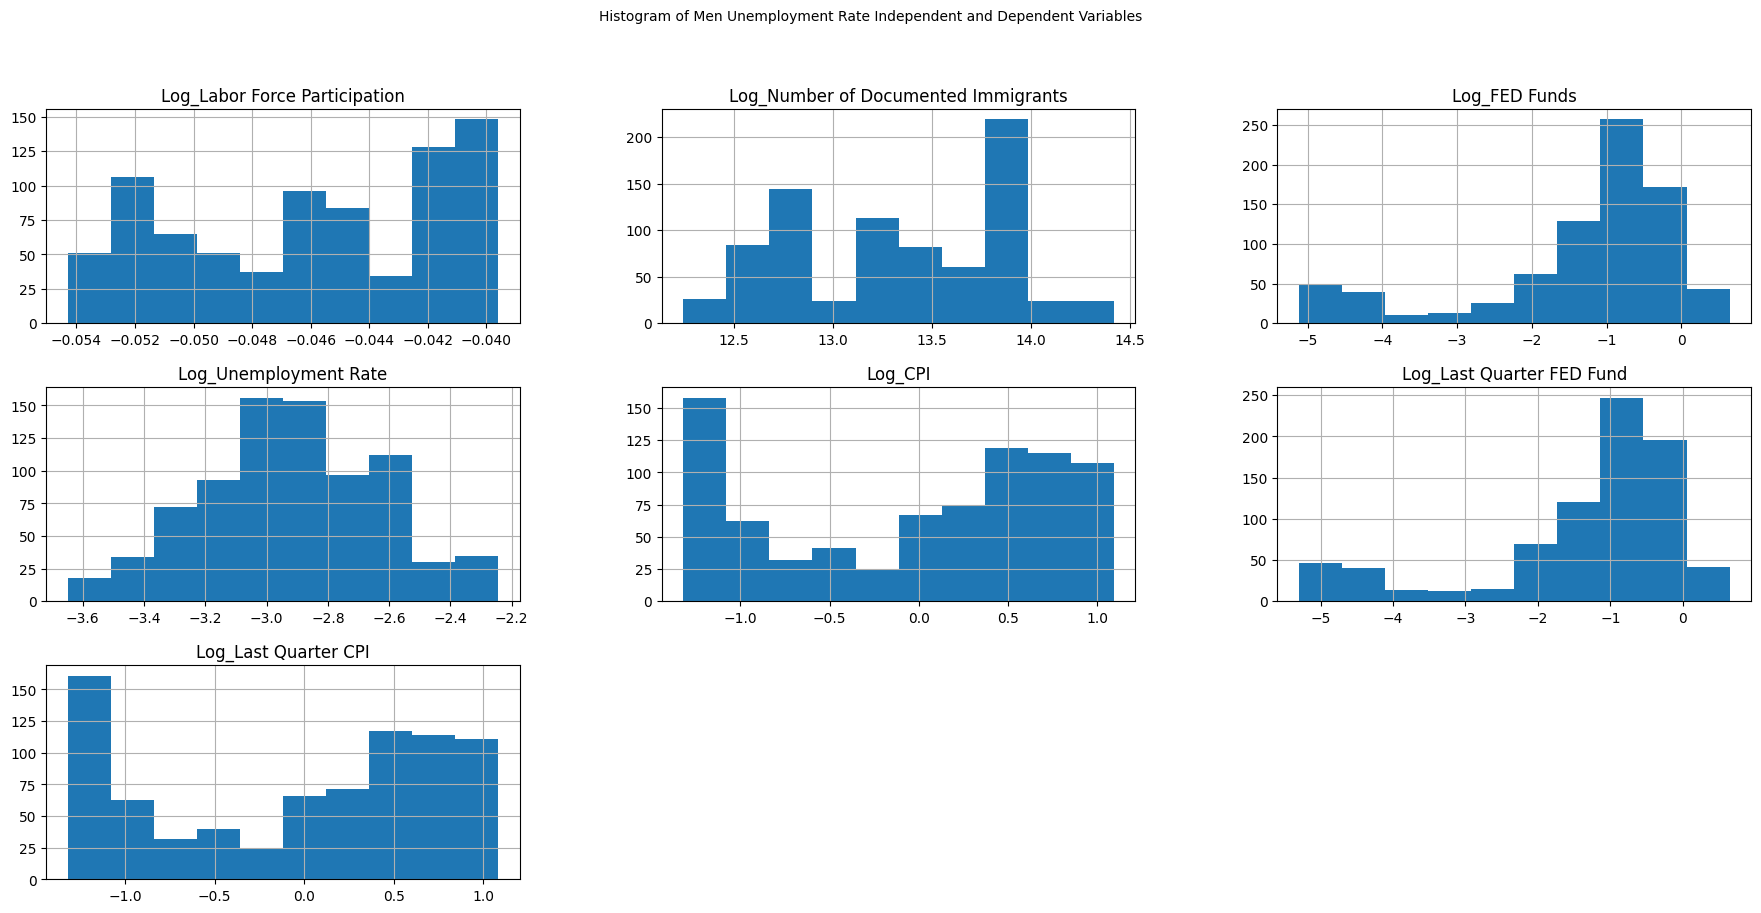

In [1160]:
# Create histograms for the subset of columns to understand if any data need transformation
subset_columns_men3=['Log_Labor Force Participation','Log_Number of Documented Immigrants','Log_FED Funds','Log_Unemployment Rate','Log_CPI','Log_Last Quarter FED Fund','Log_Last Quarter CPI']
df_men3[subset_columns_men3].hist(figsize=(22, 10), bins=10)  # Adjust figsize and bins as needed

# Add titles and labels
plt.suptitle('Histogram of Men Unemployment Rate Independent and Dependent Variables', fontsize=10)
plt.xlabel('Value', fontsize=8)
plt.ylabel('Frequency', fontsize=8)

# Show the plot
plt.show()

In [1161]:
#Adding crisis interaction term 
df_men3['Crisis_LogFED'] = df_men3['Crisis']*df_men3['Log_Last Quarter FED Fund']
df_men3['Crisis_LogImmig'] = df_men3['Crisis']*df_men3['Log_Number of Documented Immigrants']
df_men3['Crisis_LogCPI'] = df_men3['Crisis']*df_men3['Log_CPI']
df_men3['Crisis_LogLastQFED'] = df_men3['Crisis']*df_men3['Log_Last Quarter FED Fund'] 
df_men3['Crisis_LogLaborForce'] = df_men3['Crisis']*df_men3['Log_Labor Force Participation'] 
df_men3['Crisis_LogLastQCPI'] = df_men3['Crisis']*df_men3['Log_Last Quarter CPI']

In [1066]:
df_men3.columns

Index(['Date', 'Unemployment Rate', 'Labor Force Participation',
       'Real GDP Growth', 'Number of Documented Immigrants',
       'President Party Affiliation', 'FED Funds', 'CPI',
       'Last Quarter Real GDP Growth', 'Last Quarter FED Fund',
       'Last Quarter CPI', 'Year', 'Crisis', 'CPI_YJ', 'CPI_BX', 'Crisis_FED',
       'Crisis_Labor', 'Crisis_GDP', 'Crisis_President', 'Crisis_CPI',
       'Crisis_LastQCPI', 'Log_Labor Force Participation',
       'Log_Number of Documented Immigrants', 'Log_FED Funds',
       'Log_Unemployment Rate', 'Log_CPI', 'Log_Last Quarter FED Fund',
       'Log_Last Quarter CPI', 'Crisis_LogFED', 'Crisis_LogImmig',
       'Crisis_LogCPI', 'Crisis_LogLastQFED', 'Crisis_LogLaborForce',
       'Crisis_LogLastQCPI'],
      dtype='object')

In [1162]:
df_men3["Prev Two Quarter Log FED Fund"] = df_men3['Log_Last Quarter FED Fund'].shift(4)
df_men3['Crisis_Log2LastQFED'] = df_men3['Crisis']*df_men3["Prev Two Quarter Log FED Fund"] 
#drop NA for men population for regression analysis
df_men3=df_men3.dropna()
df_men3.columns


Index(['Date', 'Unemployment Rate', 'Labor Force Participation',
       'Real GDP Growth', 'Number of Documented Immigrants',
       'President Party Affiliation', 'FED Funds', 'CPI',
       'Last Quarter FED Fund', 'Last Quarter CPI', 'Crisis',
       'Last Quarter Real GDP Growth', 'Crisis_FED', 'Crisis_Labor',
       'Crisis_GDP', 'Crisis_President', 'Crisis_CPI', 'Crisis_LastQCPI',
       'Log_Labor Force Participation', 'Log_Number of Documented Immigrants',
       'Log_FED Funds', 'Log_Unemployment Rate', 'Log_CPI',
       'Log_Last Quarter FED Fund', 'Log_Last Quarter CPI', 'Crisis_LogFED',
       'Crisis_LogImmig', 'Crisis_LogCPI', 'Crisis_LogLastQFED',
       'Crisis_LogLaborForce', 'Crisis_LogLastQCPI',
       'Prev Two Quarter Log FED Fund', 'Crisis_Log2LastQFED'],
      dtype='object')

In [1187]:
#Running multiple regression analysis without data transformation for men population
# X = df_men3[['Log_Labor Force Participation','Log_Number of Documented Immigrants','Log_Last Quarter FED Fund',  'Crisis_LogImmig','Crisis_Log2LastQFED', 'Log_Last Quarter FED Fund', 
# 'Prev Two Quarter Log FED Fund','President Party Affiliation','Crisis_LogLaborForce']] #p-value: 0.009141693967036178

# X = df_men3[['Log_Labor Force Participation','Log_Number of Documented Immigrants','Log_Last Quarter FED Fund',  'Crisis_LogImmig','Crisis_Log2LastQFED', 
# 'Crisis_LogLastQFED','Prev Two Quarter Log FED Fund','President Party Affiliation','Crisis_LogLaborForce']] #p-value: 0.009457

# X = df_men3[['Log_Labor Force Participation','Log_Number of Documented Immigrants', 'Crisis_LogImmig','Crisis_Log2LastQFED', 
# 'Prev Two Quarter Log FED Fund','President Party Affiliation','Crisis_LogLaborForce']] #p-value: 0.02354811841915814

X = df_men3[['Log_Labor Force Participation','Log_Number of Documented Immigrants','Log_Last Quarter FED Fund',  'Crisis_LogImmig','Crisis_Log2LastQFED', 'Log_Last Quarter CPI',
'Crisis_LogLastQFED','Prev Two Quarter Log FED Fund','President Party Affiliation','Crisis_LogLaborForce']] # p-value: 0.02354811841915814

X = sm.add_constant(X)
model2_men = sm.OLS(df_men3['Log_Unemployment Rate'], X).fit()
# Get the residuals
residual_men2 = model2_men.resid
print("Multiple regression without log transformation:")
print(model2_men.summary())



Multiple regression without log transformation:
                              OLS Regression Results                             
Dep. Variable:     Log_Unemployment Rate   R-squared:                       0.314
Model:                               OLS   Adj. R-squared:                  0.305
Method:                    Least Squares   F-statistic:                     35.89
Date:                   Wed, 12 Jun 2024   Prob (F-statistic):           6.56e-58
Time:                           19:55:43   Log-Likelihood:                -8.8313
No. Observations:                    796   AIC:                             39.66
Df Residuals:                        785   BIC:                             91.14
Df Model:                             10                                         
Covariance Type:               nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [1220]:
df_men4 = df_men3[['Log_Unemployment Rate', 'Log_Labor Force Participation','Log_Number of Documented Immigrants','Log_Last Quarter FED Fund',  'Crisis_LogImmig','Crisis_Log2LastQFED', 'Log_Last Quarter CPI',
'Crisis_LogLastQFED','Prev Two Quarter Log FED Fund','President Party Affiliation','Crisis_LogLaborForce']]
df_men4  = df_men4 .reset_index(drop=True)
df_men4.head()

,Log_Unemployment Rate,Log_Labor Force Participation,Log_Number of Documented Immigrants,Log_Last Quarter FED Fund,Crisis_LogImmig,Crisis_Log2LastQFED,Log_Last Quarter CPI,Crisis_LogLastQFED,Prev Two Quarter Log FED Fund,President Party Affiliation,Crisis_LogLaborForce
0,-3.101093,-0.053614,12.379143,-2.488915,0.0,-0.0,-1.317515,-0.0,-2.525729,1.0,-0.0
1,-3.057608,-0.052763,12.379143,-2.055725,0.0,-0.0,-1.317888,-0.0,-2.103734,1.0,-0.0
2,-3.218876,-0.053103,12.379143,-1.973281,0.0,-0.0,-1.317888,-0.0,-2.234926,1.0,-0.0
3,-3.244194,-0.053103,12.379143,-2.047943,0.0,-0.0,-1.316022,-0.0,-2.465104,1.0,-0.0
4,-3.270169,-0.052256,12.379143,-2.002481,0.0,-0.0,-1.317142,-0.0,-2.488915,1.0,-0.0


In [1223]:
# Define the dependent and independent variables
X = df_men4[['Log_Labor Force Participation','Log_Number of Documented Immigrants','Log_Last Quarter FED Fund',  'Crisis_LogImmig','Crisis_Log2LastQFED', 'Log_Last Quarter CPI',
'Crisis_LogLastQFED','Prev Two Quarter Log FED Fund','President Party Affiliation','Crisis_LogLaborForce']] 
y = df_men4['Log_Unemployment Rate']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())


                              OLS Regression Results                             
Dep. Variable:     Log_Unemployment Rate   R-squared:                       0.314
Model:                               OLS   Adj. R-squared:                  0.305
Method:                    Least Squares   F-statistic:                     35.89
Date:                   Wed, 12 Jun 2024   Prob (F-statistic):           6.56e-58
Time:                           20:51:05   Log-Likelihood:                -8.8313
No. Observations:                    796   AIC:                             39.66
Df Residuals:                        785   BIC:                             91.14
Df Model:                             10                                         
Covariance Type:               nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [1236]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
# Define the dependent and independent variables
df_men4.columns = df_men4.columns.str.replace(' ', '_')
dependent_var = 'Log_Unemployment_Rate'
independent_vars = ['Log_Labor_Force_Participation', 'Log_Number_of_Documented_Immigrants', 
                    'Log_Last_Quarter_FED_Fund', 'Crisis_LogImmig', 'Crisis_Log2LastQFED', 
                    'Log_Last_Quarter_CPI', 'Crisis_LogLastQFED', 'Prev_Two_Quarter_Log_FED_Fund', 
                    'President_Party_Affiliation', 'Crisis_LogLaborForce']



# Prepare the formula for the OLS regression
formula = f'{dependent_var} ~ ' + ' + '.join(independent_vars)

# Fit the OLS model
model = ols(formula, data=df_men4).fit()

# Perform ANOVA test
anova_results = anova_lm(model)

# Display the ANOVA results
print(anova_results)

                                        df     sum_sq   mean_sq           F  \
Log_Labor_Force_Participation          1.0   7.451946  7.451946  122.762016   
Log_Number_of_Documented_Immigrants    1.0   0.008461  0.008461    0.139392   
Log_Last_Quarter_FED_Fund              1.0   5.313260  5.313260   87.529691   
Crisis_LogImmig                        1.0   4.980013  4.980013   82.039837   
Crisis_Log2LastQFED                    1.0   0.841596  0.841596   13.864297   
Log_Last_Quarter_CPI                   1.0   0.312420  0.312420    5.146758   
Crisis_LogLastQFED                     1.0   0.858824  0.858824   14.148114   
Prev_Two_Quarter_Log_FED_Fund          1.0   1.330080  1.330080   21.911504   
President_Party_Affiliation            1.0   0.484539  0.484539    7.982212   
Crisis_LogLaborForce                   1.0   0.206883  0.206883    3.408156   
Residual                             785.0  47.651362  0.060702         NaN   

                                           PR(>F)  

<Figure size 800x600 with 0 Axes>

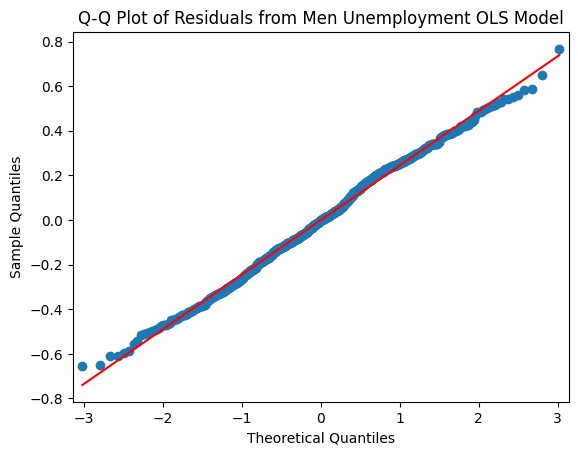

In [1326]:
# Q-Q plot for the model1_men residuals
plt.figure(figsize=(8, 6))
sm.qqplot(residual_men2, line='s')
plt.title('Q-Q Plot of Residuals from Men Unemployment OLS Model')
plt.show()

In [1188]:
# Shapiro-Wilk test for normality of residual
shapiro_test = shapiro(residual_men2)
print('Shapiro-Wilk Test:')
print(f'Statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}')

Shapiro-Wilk Test:
Statistic: 0.9956162506608792, p-value: 0.02354811841915814


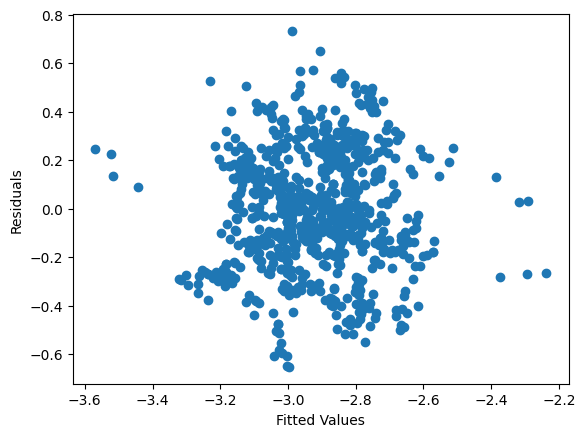

In [1125]:
#Ensure that the residuals have constant variance (homoscedasticity).
# Residuals vs. Fitted values plot
plt.scatter(model2_men.fittedvalues, model2_men.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

In [1190]:
#Ensure residuals are independent
from statsmodels.stats.stattools import durbin_watson

dw_test = durbin_watson(model2_men.resid)
print('Durbin-Watson Test:', dw_test)

#Confirm residuals are independent

Durbin-Watson Test: 0.10253851830265602


In [ ]:
#Women Unemployment Analysis

In [1298]:
#merge all data for all women 
df_women= pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(unemployment_women, gdp_data, on = "YearMonth" ),laborforce_data, on = "YearMonth"),cpi_data, on = "YearMonth"),monthly_immig_data, on = "YearMonth", how = "left"),president_data, on = "YearMonth"),fedfund_data,on = "YearMonth")
df_women.head()

,DATE,LNS14000002,YearMonth,USALORSGPNOSTSAM,USALORSGPNOSTSAM1,Labor Force Participation,CPI,NUMBER OF DOCUMENTED IMMIGRANTS,President Party Affiliation,FEDFUNDS
0,1954-07-01,6.3,1954-07-01,97.80396,97.98277,58.4,26.86,208177.0,1.0,0.80
1,1954-08-01,6.2,1954-08-01,97.98277,98.24867,58.7,26.85,208177.0,1.0,1.22
2,1954-09-01,6.4,1954-09-01,98.24867,98.59119,59.2,26.81,208177.0,1.0,1.07
3,1954-10-01,5.8,1954-10-01,98.59119,98.99624,58.8,26.72,208177.0,1.0,0.85
4,1954-11-01,5.6,1954-11-01,98.99624,99.44441,58.6,26.78,208177.0,1.0,0.83


In [1299]:
#normalize GDP via CPI, and other data
df_women["Real GDP"] = df_women['USALORSGPNOSTSAM'] / df_women['CPI']
df_women["Real GDP1"] = df_women['USALORSGPNOSTSAM1'] / df_women['CPI']
df_women["Real GDP Growth"] = (df_women["Real GDP1"] - df_women["Real GDP"])/df_women["Real GDP"]*100
df_women=df_women[['YearMonth', 'LNS14000002','Labor Force Participation','Real GDP Growth','NUMBER OF DOCUMENTED IMMIGRANTS', 'President Party Affiliation','FEDFUNDS', "CPI"]]
#scale labor force and umemployment data
df_women['Labor Force Participation'] = df_women['Labor Force Participation']/100
df_women['LNS14000002'] = df_women['LNS14000002']/100
#add last quarter lagged real GDP growth and FED Fund
df_women["Lag4 Real GDP Growth"]= df_women['Real GDP Growth'].shift(4)
df_women["Lag4 FED Fund"]= df_women['FEDFUNDS'].shift(4)
df_women["Lag4 CPI"]= df_women['CPI'].shift(4)

In [1300]:
#change project 1 women dataset name
df_women.rename(columns={'YearMonth': 'Date', 'LNS14000002': 'Unemployment Rate', 'Labor Force Participation':'Labor Force Participation',
                    'Real GDP Growth':'Real GDP Growth', "Lag4 Real GDP Growth":"Last Quarter Real GDP Growth", "NUMBER OF DOCUMENTED IMMIGRANTS": "Number of Documented Immigrants",'President Party Affiliation':'President Party Affiliation','FEDFUNDS':'FED Funds', 'CPI':'CPI','Lag4 FED Fund':'Last Quarter FED Fund','Lag4 CPI':'Last Quarter CPI'}, inplace=True)

In [1301]:
#Create a US economic crisis column with dummy variable =1 if crisis and 0 otherwise
df_women['Year'] = df_women['Date'].dt.year

# Define the years considered as crisis years
crisis_years = [1948, 1949, 1953,1954,1957,1958,1960,1961,1969,1970,1973,1974,1975,1980,1981,1982,1990,1991,2001,2008,2009,2020]

# Create a new column 'Crisis' and set values based on the year
df_women['Crisis'] = df_women['Year'].apply(lambda x: 1 if x in crisis_years else 0)

df_women=df_women[['Date', 'Unemployment Rate','Labor Force Participation','Real GDP Growth','Number of Documented Immigrants', 'President Party Affiliation','FED Funds', "CPI",'Last Quarter FED Fund','Last Quarter CPI','Crisis','Last Quarter Real GDP Growth']]


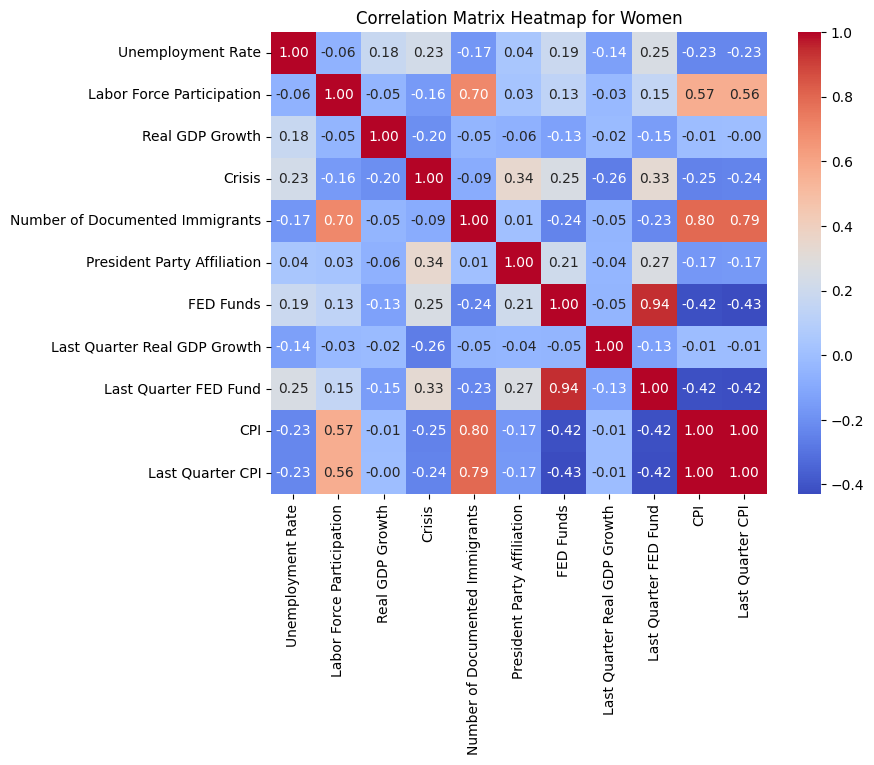

In [1279]:
#correlation analysis of all variables of interest for women
subset_columns_women = ['Unemployment Rate', 'Labor Force Participation', 'Real GDP Growth','Crisis',"Number of Documented Immigrants",'President Party Affiliation', 'FED Funds','Last Quarter Real GDP Growth',
'Last Quarter FED Fund','CPI','Last Quarter CPI']

# Compute the correlation matrix for the subset of columns
correlation_matrix_women = df_women[subset_columns_women].corr()
# print("\nCorrelation matrix for women unemployment rate:")
# print(correlation_matrix_women)

#print correlation for women
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_women, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap for Women')
plt.show()

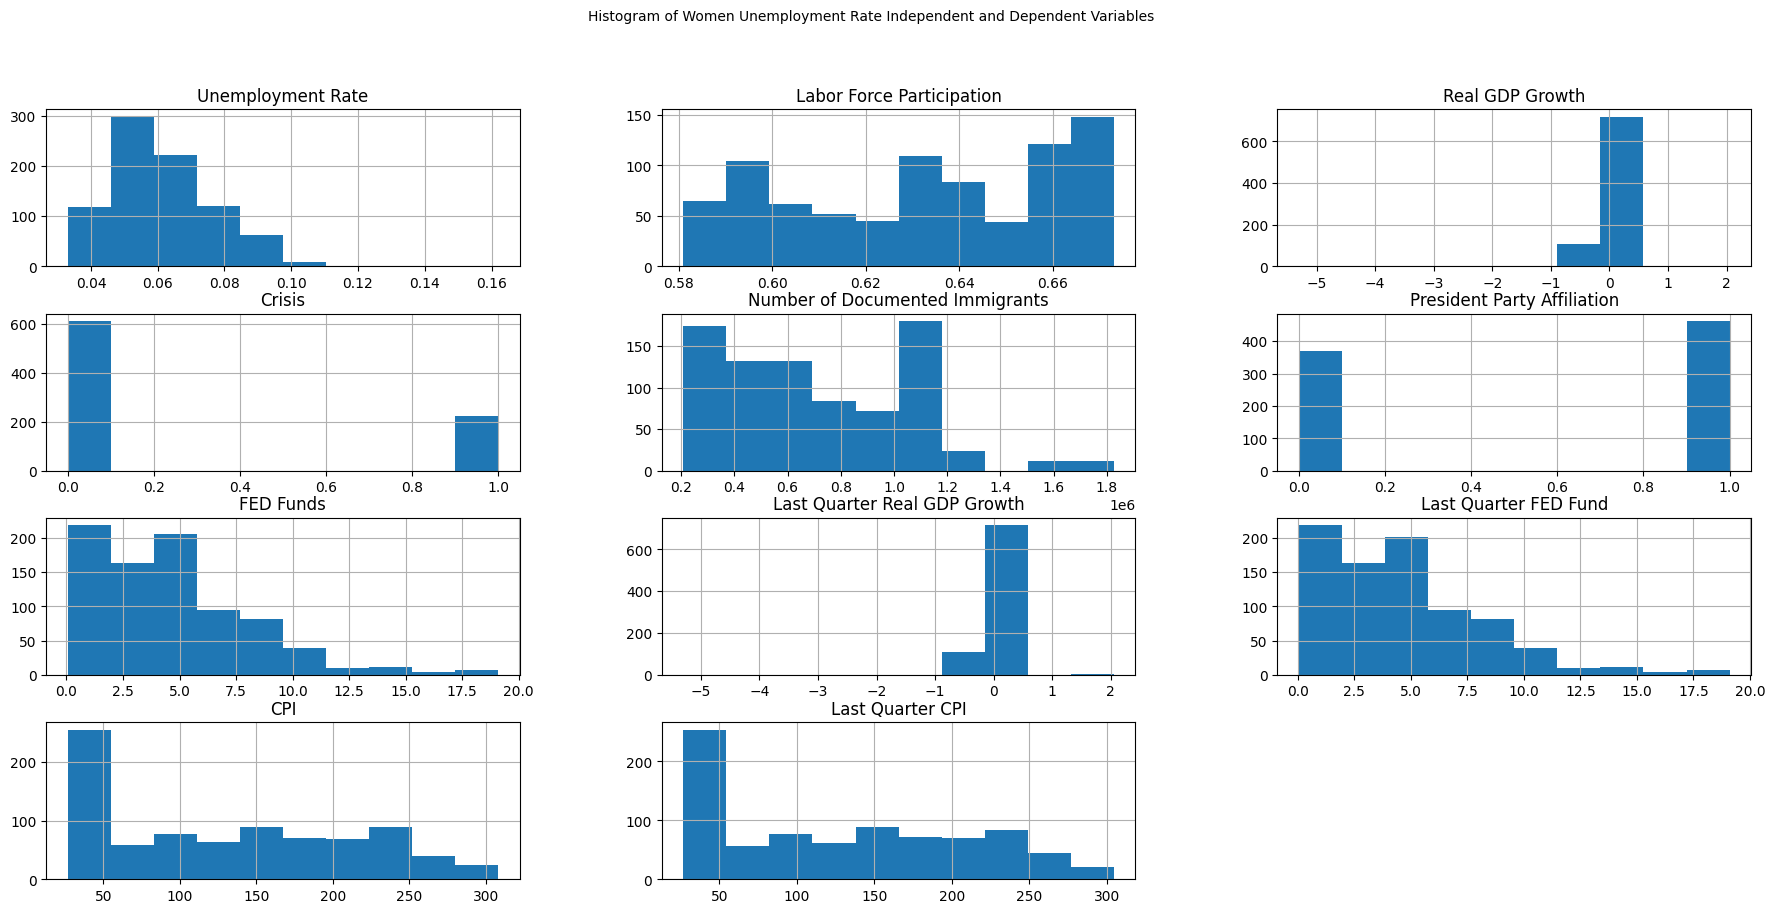

In [1280]:
# Create histograms for the subset of columns to understand if any data need transformation
df_women[subset_columns_women].hist(figsize=(22, 10), bins=10)  # Adjust figsize and bins as needed

# Add titles and labels
plt.suptitle('Histogram of Women Unemployment Rate Independent and Dependent Variables', fontsize=10)
plt.xlabel('Value', fontsize=8)
plt.ylabel('Frequency', fontsize=8)

# Show the plot
plt.show()

#Many data are skewed and require transformation

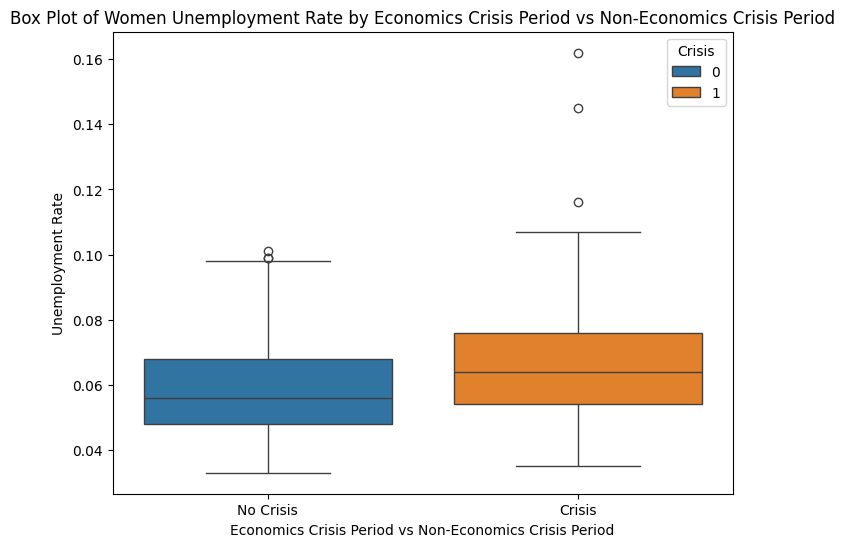

In [1281]:
# Create a box plot with hue for women
plt.figure(figsize=(8, 6))
sns.boxplot(x='Crisis', y='Unemployment Rate', hue='Crisis', data=df_women)
plt.title('Box Plot of Women Unemployment Rate by Economics Crisis Period vs Non-Economics Crisis Period')
plt.xlabel('Economics Crisis Period vs Non-Economics Crisis Period')
plt.ylabel('Unemployment Rate')
# Modify the x-axis labels
new_labels = ['No Crisis', 'Crisis']
plt.xticks(ticks=[0, 1], labels=new_labels)
plt.show()
#Outlier exist and need to be removed

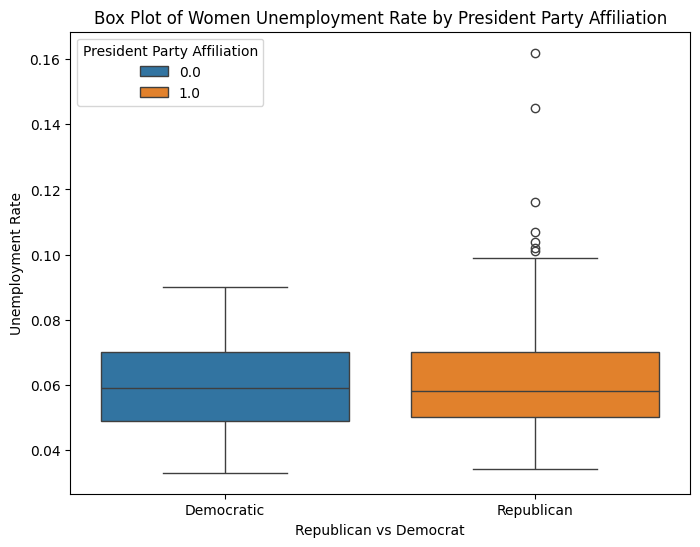

In [1282]:
# Create a box plot with hue for women
plt.figure(figsize=(8, 6))
sns.boxplot(x='President Party Affiliation', y='Unemployment Rate', hue='President Party Affiliation', data=df_women)
plt.title('Box Plot of Women Unemployment Rate by President Party Affiliation')
plt.xlabel('Republican vs Democrat')
plt.ylabel('Unemployment Rate')
# Modify the x-axis labels
new_labels = ['Democratic', 'Republican']
plt.xticks(ticks=[0, 1], labels=new_labels)
plt.show()


In [1302]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) to identify outlier
Q1 = df_women['Unemployment Rate'].quantile(0.25)
Q3 = df_women['Unemployment Rate'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers 
outliers_iqr = df_women[(df_women['Unemployment Rate'] < lower_bound) | (df_women['Unemployment Rate'] > upper_bound)]

# print("\nOutliers using IQR method:")
# print(outliers_iqr)

In [1303]:
#drop NA for women population for regression analysis
df_women=df_women.dropna()
nan_counts = df_women.isna().sum()

# print("Number of NaNs in each column:")
# print(nan_counts)

In [1304]:
#Adding crisis interaction term 
df_women2=df_women.copy()
df_women2['Crisis_FED'] = df_women2['Crisis']*df_women2['Last Quarter FED Fund']
df_women2['Crisis_Labor'] = df_women2['Crisis']*df_women2['Labor Force Participation']
df_women2['Crisis_GDP'] = df_women2['Crisis']*df_women2['Last Quarter Real GDP Growth']
df_women2['Crisis_President'] = df_women2['Crisis']*df_women2['President Party Affiliation']
df_women2['Crisis_CPI'] = df_women2['Crisis']*df_women2['CPI']
df_women2['Crisis_LastQCPI'] = df_women2['Crisis']*df_women2['Last Quarter CPI']

In [1305]:
#Drop outliers
df_women2 = df_women2[~((df_women2['Unemployment Rate'] < lower_bound) | (df_women2['Unemployment Rate'] > upper_bound))]
df_women2.head()

,Date,Unemployment Rate,Labor Force Participation,Real GDP Growth,Number of Documented Immigrants,President Party Affiliation,FED Funds,CPI,Last Quarter FED Fund,Last Quarter CPI,Crisis,Last Quarter Real GDP Growth,Crisis_FED,Crisis_Labor,Crisis_GDP,Crisis_President,Crisis_CPI,Crisis_LastQCPI
4,1954-11-01,0.056,0.586,0.452714,208177.0,1.0,0.83,26.78,0.80,26.86,1,0.182825,0.80,0.586,0.182825,1.0,26.78,26.86
5,1954-12-01,0.052,0.581,0.462691,208177.0,1.0,1.28,26.77,1.22,26.85,1,0.271374,1.22,0.581,0.271374,1.0,26.77,26.85
6,1955-01-01,0.053,0.586,0.439089,237790.0,1.0,1.39,26.77,1.07,26.81,0,0.348626,0.00,0.000,0.000000,0.0,0.00,0.00
7,1955-02-01,0.050,0.584,0.388965,237790.0,1.0,1.29,26.82,0.85,26.72,0,0.410838,0.00,0.000,0.000000,0.0,0.00,0.00
8,1955-03-01,0.048,0.585,0.329682,237790.0,1.0,1.35,26.79,0.83,26.78,0,0.452714,0.00,0.000,0.000000,0.0,0.00,0.00


In [1306]:
#Create a copy of df_women2 for log transformation
df_women3=df_women2.copy()
# df_women3.head()

In [1307]:
#Log transform a subset of dependent variables
df_women3['Log_Labor Force Participation'] = np.log(df_women3['Labor Force Participation'])/10
df_women3['Log_Number of Documented Immigrants'] = np.log(df_women3['Number of Documented Immigrants'])
df_women3['Log_FED Funds'] = np.log(df_women3['FED Funds']/10)
df_women3['Log_Unemployment Rate'] = np.log(df_women3['Unemployment Rate'])
df_women3['Log_CPI'] = np.log(df_women3['CPI']/100)
df_women3['Log_Last Quarter FED Fund'] = np.log(df_women3['Last Quarter FED Fund']/10)
df_women3['Log_Last Quarter CPI'] = np.log(df_women3['Last Quarter CPI']/100)
# df_women3.head()

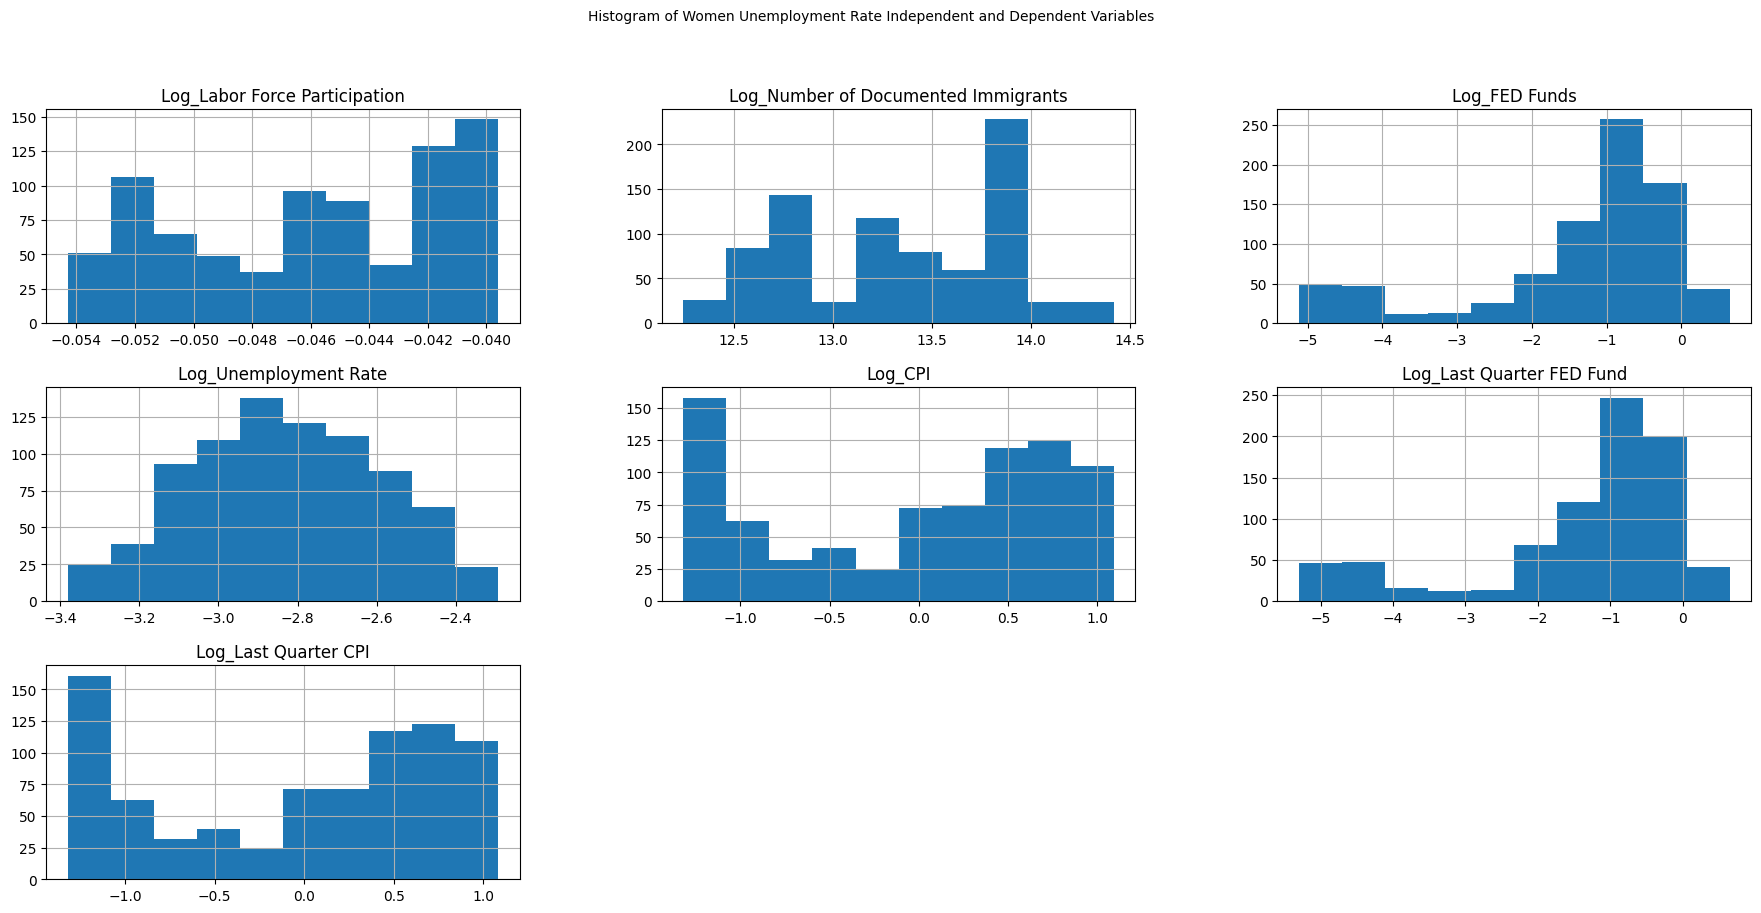

In [1308]:
# Create histograms for the subset of columns to understand if any data need transformation
subset_columns_women3=['Log_Labor Force Participation','Log_Number of Documented Immigrants','Log_FED Funds','Log_Unemployment Rate','Log_CPI','Log_Last Quarter FED Fund','Log_Last Quarter CPI']
df_women3[subset_columns_women3].hist(figsize=(22, 10), bins=10)  # Adjust figsize and bins as needed

# Add titles and labels
plt.suptitle('Histogram of Women Unemployment Rate Independent and Dependent Variables', fontsize=10)
plt.xlabel('Value', fontsize=8)
plt.ylabel('Frequency', fontsize=8)

# Show the plot
plt.show()

In [1309]:
#Adding crisis interaction term 
df_women3['Crisis_LogFED'] = df_women3['Crisis']*df_women3['Log_Last Quarter FED Fund']
df_women3['Crisis_LogImmig'] = df_women3['Crisis']*df_women3['Log_Number of Documented Immigrants']
df_women3['Crisis_LogCPI'] = df_women3['Crisis']*df_women3['Log_CPI']
df_women3['Crisis_LogLastQFED'] = df_women3['Crisis']*df_women3['Log_Last Quarter FED Fund'] 
df_women3['Crisis_LogLaborForce'] = df_women3['Crisis']*df_women3['Log_Labor Force Participation'] 
df_women3['Crisis_LogLastQCPI'] = df_women3['Crisis']*df_women3['Log_Last Quarter CPI']

In [1291]:
df_women3.columns

Index(['Date', 'Unemployment Rate', 'Labor Force Participation',
       'Real GDP Growth', 'Number of Documented Immigrants',
       'President Party Affiliation', 'FED Funds', 'CPI',
       'Last Quarter FED Fund', 'Last Quarter CPI', 'Crisis',
       'Last Quarter Real GDP Growth', 'Crisis_FED', 'Crisis_Labor',
       'Crisis_GDP', 'Crisis_President', 'Crisis_CPI', 'Crisis_LastQCPI',
       'Log_Labor Force Participation', 'Log_Number of Documented Immigrants',
       'Log_FED Funds', 'Log_Unemployment Rate', 'Log_CPI',
       'Log_Last Quarter FED Fund', 'Log_Last Quarter CPI', 'Crisis_LogFED',
       'Crisis_LogImmig', 'Crisis_LogCPI', 'Crisis_LogLastQFED',
       'Crisis_LogLaborForce', 'Crisis_LogLastQCPI'],
      dtype='object')

In [1310]:
df_women3["Prev Two Quarter Log FED Fund"] = df_women3['Log_Last Quarter FED Fund'].shift(4)
df_women3['Crisis_Log2LastQFED'] = df_women3['Crisis']*df_women3["Prev Two Quarter Log FED Fund"] 
#drop NA for women population for regression analysis
df_women3=df_women3.dropna()

In [1311]:
#Running multiple regression analysis without data transformation for women population
X = df_women3[['Log_Labor Force Participation','Log_Number of Documented Immigrants','Log_Last Quarter FED Fund',  'Crisis_LogImmig','Crisis_Log2LastQFED', 
'Crisis_LogLastQFED','Prev Two Quarter Log FED Fund','President Party Affiliation','Crisis_LogLaborForce']] #All p-value: 0.0010886559066923618

#X = df_women3[['Log_Number of Documented Immigrants','Log_Last Quarter FED Fund',  'Crisis_LogImmig','Crisis_Log2LastQFED', 
#'Crisis_LogLastQFED','Prev Two Quarter Log FED Fund','President Party Affiliation','Crisis_LogLaborForce']] # Log_Labor Force Participation p-value: 6.524608956208597e-05

#X = df_women3[['Log_Labor Force Participation','Log_Last Quarter FED Fund', 'Crisis_LogImmig','Crisis_Log2LastQFED', 
#'Crisis_LogLastQFED','Prev Two Quarter Log FED Fund','President Party Affiliation','Crisis_LogLaborForce']] #,'Log_Number of Documented Immigrants' p-value: 0.00019490983973964937

#X = df_women3[['Log_Labor Force Participation','Log_Number of Documented Immigrants',  'Crisis_LogImmig','Crisis_Log2LastQFED', 
#'Crisis_LogLastQFED','Prev Two Quarter Log FED Fund','President Party Affiliation','Crisis_LogLaborForce']] #,'Log_Last Quarter FED Fund' p-value: 4.37210012657053e-05

#X = df_women3[['Log_Labor Force Participation','Log_Number of Documented Immigrants','Log_Last Quarter FED Fund','Crisis_Log2LastQFED', 
#'Crisis_LogLastQFED','Prev Two Quarter Log FED Fund','President Party Affiliation','Crisis_LogLaborForce']] #,  'Crisis_LogImmig'p-value: 0.0001787815634624955

#X = df_women3[['Log_Labor Force Participation','Log_Number of Documented Immigrants','Log_Last Quarter FED Fund',  'Crisis_LogImmig','Crisis_Log2LastQFED', 
#'Crisis_LogLastQFED','Prev Two Quarter Log FED Fund','President Party Affiliation','Crisis_LogLaborForce', 'Log_CPI', 'Last Quarter Real GDP Growth']] #All +adding Log_CPI', 'Last Quarter Real GDP Growth' p-value:1.8865514166100433e-05

X = sm.add_constant(X)
model2_women = sm.OLS(df_women3['Log_Unemployment Rate'], X).fit()
# Get the residuals
residual_women2 = model2_women.resid
print("Multiple regression without log transformation:")
print(model2_women.summary())

# X = df_women3[['Log_Labor Force Participation','Log_Number of Documented Immigrants','Log_Last Quarter FED Fund',  'Crisis_LogImmig','Crisis_Log2LastQFED', 
# 'Crisis_LogLastQFED','Prev Two Quarter Log FED Fund','President Party Affiliation','Crisis_LogLaborForce']]

Multiple regression without log transformation:
                              OLS Regression Results                             
Dep. Variable:     Log_Unemployment Rate   R-squared:                       0.197
Model:                               OLS   Adj. R-squared:                  0.188
Method:                    Least Squares   F-statistic:                     21.75
Date:                   Thu, 13 Jun 2024   Prob (F-statistic):           3.76e-33
Time:                           18:55:58   Log-Likelihood:                 104.40
No. Observations:                    808   AIC:                            -188.8
Df Residuals:                        798   BIC:                            -141.8
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [1313]:
# Define the dependent and independent variables
df_women4 = df_women3.copy()
df_women4.columns = df_women4.columns.str.replace(' ', '_')
dependent_var = 'Log_Unemployment_Rate'
independent_vars = ['Log_Labor_Force_Participation', 'Log_Number_of_Documented_Immigrants', 
                    'Log_Last_Quarter_FED_Fund', 'Crisis_LogImmig', 'Crisis_Log2LastQFED', 
                    'Log_Last_Quarter_CPI', 'Crisis_LogLastQFED', 'Prev_Two_Quarter_Log_FED_Fund', 
                    'President_Party_Affiliation', 'Crisis_LogLaborForce']



# Prepare the formula for the OLS regression
formula = f'{dependent_var} ~ ' + ' + '.join(independent_vars)

# Fit the OLS model
model = ols(formula, data=df_women4).fit()

# Perform ANOVA test
anova_results = anova_lm(model)

# Display the ANOVA results
print(anova_results)

                                        df     sum_sq   mean_sq          F  \
Log_Labor_Force_Participation          1.0   0.138680  0.138680   3.082139   
Log_Number_of_Documented_Immigrants    1.0   2.354806  2.354806  52.335193   
Log_Last_Quarter_FED_Fund              1.0   0.738223  0.738223  16.406893   
Crisis_LogImmig                        1.0   2.015783  2.015783  44.800446   
Crisis_Log2LastQFED                    1.0   0.537404  0.537404  11.943715   
Log_Last_Quarter_CPI                   1.0   1.564097  1.564097  34.761814   
Crisis_LogLastQFED                     1.0   0.274990  0.274990   6.111618   
Prev_Two_Quarter_Log_FED_Fund          1.0   1.636875  1.636875  36.379288   
President_Party_Affiliation            1.0   0.078531  0.078531   1.745337   
Crisis_LogLaborForce                   1.0   0.297976  0.297976   6.622466   
Residual                             797.0  35.860775  0.044995        NaN   

                                           PR(>F)  
Log_Labor_F

<Figure size 800x600 with 0 Axes>

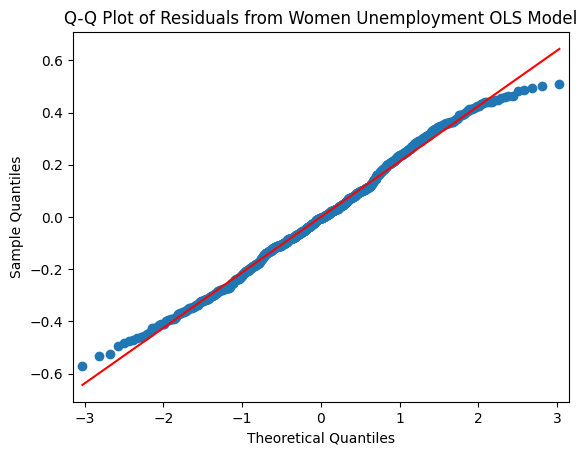

In [1314]:
# Q-Q plot for the model1_men residuals
plt.figure(figsize=(8, 6))
sm.qqplot(residual_women2, line='s')
plt.title('Q-Q Plot of Residuals from Women Unemployment OLS Model')
plt.show()

In [1315]:
# Shapiro-Wilk test for normality of residual
shapiro_test = shapiro(residual_women2)
print('Shapiro-Wilk Test:')
print(f'Statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}')

Shapiro-Wilk Test:
Statistic: 0.9932901990164407, p-value: 0.001088655906695082


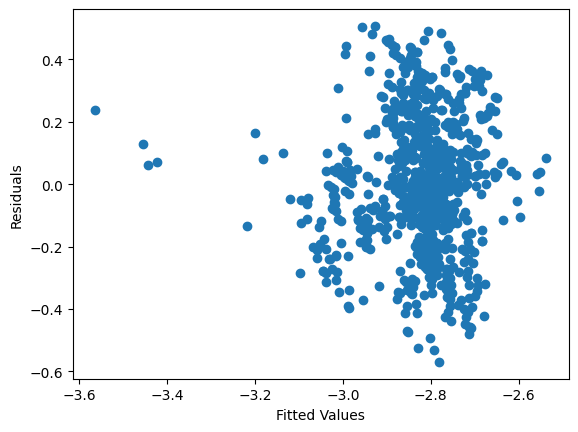

In [1316]:
#Ensure that the residuals have constant variance (homoscedasticity).
# Residuals vs. Fitted values plot
plt.scatter(model2_women.fittedvalues, model2_women.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()
